In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import math

In [3]:
np.random.seed(100)
N = 500 # number of data points

In [4]:
t = np.linspace(0, 4*np.pi, N)
# t = t/(max(t))
data = 15.0*np.sin(t+0.001) + 0.05 + np.random.randn(N) # create artificial data with noise
# data = 3.0*np.sin(t+100) 

In [5]:
df= pd.DataFrame({'X1':t, 'Y':data})

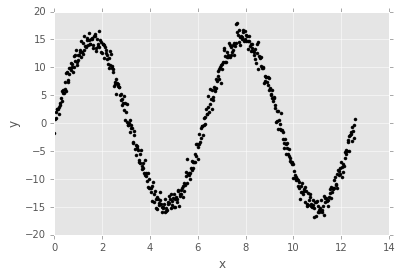

In [6]:
def plot_data(data =df):
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data()

In [7]:
def polynomial_data(data, power =1):
    tmp_df = pd.DataFrame()
    col_degree = ['X'+str(i) for i in range(1,power+1)]
    
    for i in range(1,power+1):
        tmp_df[col_degree[i-1]]=df['X1']**i
        
    return tmp_df

In [8]:
#5 degree polynomial
# df_poly = pd.concat([polynomial_data(df,5), df['Y']], axis=1)

In [9]:
#n degree polynomial
df_poly = pd.concat([polynomial_data(df,5), df['Y']], axis=1)

In [10]:
df_poly.head()

,X1,X2,X3,X4,X5,Y
0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.684765
1,0.025183,0.000634,0.000016,4.021956e-07,1.012853e-08,0.785382
2,0.050366,0.002537,0.000128,6.435129e-06,3.241131e-07,1.973190
3,0.075549,0.005708,0.000431,3.257784e-05,2.461234e-06,0.944683
4,0.100732,0.010147,0.001022,1.029621e-04,1.037162e-05,2.554676


In [11]:
import h2o
h2o.init(min_mem_size='2G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,46 mins 51 secs
H2O cluster version:,3.10.4.1
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_user_ykmbu1
H2O cluster total nodes:,1
H2O cluster free memory:,1.884 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [ ]:
hdf= h2o.H2OFrame(df_poly)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)

In [ ]:
input_name= hdf.col_names
input_name.remove('Y')
print input_name

In [ ]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator


In [ ]:
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator


In [ ]:
nfolds =5
my_gbm = H2OGradientBoostingEstimator(ntrees=10,
                                      max_depth=3,
                                      min_rows=2,
                                      learn_rate=0.2,
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)

# Train and cross-validate a RF
my_rf = H2ORandomForestEstimator(ntrees=50,
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 seed=1)
my_rf.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)



# Train a stacked ensemble using the GBM and GLM above
# ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial",
#                                        base_models=[my_gbm.model_id, my_rf.model_id])
# ensemble.train(x = input_name, y = 'Y', training_frame=hdf_train, validation_frame=hdf_validate)

In [ ]:
meta_learner = H2ODeepLearningEstimator(seed =10,
                                        hidden =[10,10,10,10,10,10,10],
                                        epochs =2550,
                                        l2=1e-3, 
                                        model_id='dl10',
                                        overwrite_with_best_model = False,
                                        rate = 0.5
                                       )

In [ ]:
def get_level_one_data(base_model=[my_gbm, my_rf], response = 'Y', data = hdf_train, remove_response = False): 
    level_one_data= data[response]
    
    for i in base_model:
        level_one_data = level_one_data.cbind(i.predict(data))
    if(remove_response == False):
        return level_one_data
    elif(remove_response == True):
        level_one_data = level_one_data.drop('Y')
        return level_one_data


In [ ]:
def esemble_prediction(level_one_data, base_model=[my_gbm, my_rf], response = 'Y'):
    
    x = level_one_data.col_names
    x.remove(response)

    level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

    meta_learner.train(x = x, y = response, training_frame = level_one_data_test,
                       validation_frame=level_one_data_valid)
    

In [ ]:
esemble_prediction(level_one_data=get_level_one_data())

In [ ]:
meta_learner.plot()

In [ ]:
print 'train mse: ', meta_learner.mse(train=True)
print 'valid mse: ', meta_learner.mse(valid=True)

In [ ]:
base_learner_prediction = get_level_one_data(data=hdf_validate, remove_response= True)

In [ ]:
base_learner_prediction

In [ ]:
prediction= meta_learner.predict(base_learner_prediction)

prediction['target']=hdf_validate['Y']
output= prediction.as_data_frame()
output.plot()

In [ ]:
prediction= my_gbm.predict(hdf_validate)

prediction['target']=hdf_validate['Y']
output= prediction.as_data_frame()
output.plot()

In [ ]:
prediction= my_rf.predict(hdf_validate)

prediction['target']=hdf_validate['Y']
output= prediction.as_data_frame()
output.plot()